#**AI-Powered Recruitment Automation System**

##**Workflow:**
**Supervisor Agent** is connected with the following Agents,
* Job Description Geneartor Agent
* Resume Scanner Agent
  * If Resume matched with job description
    * Interviewer / Human in Loop Node (Selected/Rejected)
      * If Selected
        * OnBorad Process Agent
      * If Rejected
        * End
  * If Resume does not match with job description
    * Early Rejection


In [ ]:
!pip install langchain langchain-openai langgraph langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.8 MB/s eta 0:00:00


In [ ]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
api_key = userdata.get('openai_api_key')

In [ ]:
from typing import TypedDict, Literal, Annotated, List
from operator import add
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)

##**Job Description Generator**

In [ ]:
# ---------------------------
# Step 1: Define State Schema
# ---------------------------

class InputState(TypedDict):
    requirement: str  # HR input like "Need a Python Backend Engineer"

class OutputState(TypedDict):
    jd_output: str

class JDState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

# --------------------------
# Step 2: Define Tool
# --------------------------

@tool
def generate_jd(role_description: str) -> str:
    """Generate a job description for the given role"""
    return f"Auto-generated JD for: {role_description}"  # placeholder

tools_jd = [generate_jd]

# --------------------------
# Step 3: Bind Model
# --------------------------

model_jd = llm.bind_tools(tools_jd)

# --------------------------
# Step 4: Agent Logic
# --------------------------

def call_model_jd_generator(state: JDState) -> JDState:
    local_messages = state.get("messages", [])
    if not local_messages:
        local_messages.append(HumanMessage(content=state["requirement"]))

    system_message = SystemMessage(content="""You are a professional HR assistant.
Generate a clear, concise job description using the provided requirement in 50 words.""")

    response = model_jd.invoke([system_message] + local_messages)

    state["jd_output"] = response.content
    state["messages"] = local_messages + [response]
    return state

def should_continue_jd(state: JDState) -> Literal["tools", END]:
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    return END

# --------------------------
# Step 5: JD Agent Subgraph
# --------------------------

jd_graph = StateGraph(JDState, input=InputState, output=OutputState)
jd_graph.add_node("call_model_jd_generator", call_model_jd_generator)
jd_graph.add_node("tools", ToolNode(tools_jd))
jd_graph.add_edge(START, "call_model_jd_generator")
jd_graph.add_conditional_edges("call_model_jd_generator", should_continue_jd)
jd_graph.add_edge("tools", "call_model_jd_generator")

jd_generator_agent = jd_graph.compile()


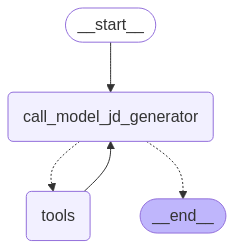

In [ ]:
# --------------------------
# Step 6: Display Graph
# --------------------------

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        jd_generator_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# ----------------------------------
# Step 7: Run Job Description Agent
# ----------------------------------
result=jd_generator_agent.invoke({"requirement": "We need a data scientist with ML and Python expertise"})

In [ ]:
print("Generated JD:",result['jd_output'])

Generated JD: **Job Title: Data Scientist**

We are seeking a Data Scientist with expertise in Machine Learning and Python. The ideal candidate will analyze complex data sets, develop predictive models, and provide actionable insights to drive business decisions. Strong coding skills and experience with data visualization tools are essential.


##**Resume Scanner Agent**

In [ ]:
# ---------------------------
# Step 1: Define State Schema
# ---------------------------
class ResumeInputState(TypedDict):
    jd_output: str
    resume: str

class ResumeOutputState(TypedDict):
    match_result: str

class ResumeMatchingState(ResumeInputState, ResumeOutputState):
    messages: Annotated[List[BaseMessage], add]


In [ ]:
# ----------------------------------------
# Step 2: Helper functions to Define Tool
# ----------------------------------------
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

# Prompt to extract skills from text
skill_extraction_prompt = PromptTemplate.from_template("""
You are an expert technical recruiter. Extract only the relevant technical and soft skills from the following text.
Return them as a Python list of strings.

Text:
{text}

Skills List:
""")

# Chain to extract skills using LLM
skill_extractor_chain = skill_extraction_prompt | llm | StrOutputParser()

# Use with job description
def extract_skills_from_jd(job_description: str) -> list:
    result = skill_extractor_chain.invoke({"text": job_description})
    try:
        return eval(result.strip())
    except Exception:
        return []

# Use with resume
def extract_skills_from_resume(resume_text: str) -> list:
    result = skill_extractor_chain.invoke({"text": resume_text})
    try:
        return eval(result.strip())
    except Exception:
        return []


In [ ]:

# --------------------------
# Step 3: Define Tool
# --------------------------
@tool
def check_resume_match(jd: str, resume: str) -> str:
    """Check whether the resume matches the job description."""
    # Parse the job description and resume to extract required and present skills
    required_skills = extract_skills_from_jd(jd)
    candidate_skills = extract_skills_from_resume(resume)

    # Calculate the match percentage based on the presence of required skills
    matched_skills = required_skills.intersection(candidate_skills)
    match_percentage = (len(matched_skills) / len(required_skills)) * 100

    # Generate reasoning
    missing_skills = required_skills - matched_skills
    reasoning = f"Matched skills: {matched_skills}. Missing skills: {missing_skills}."

    return f"**Match Percentage: {match_percentage}%**\n**Reasoning:** {reasoning}"


In [ ]:
# --------------------------
# Step 4: Bind Tool
# --------------------------
tools_rm = [check_resume_match]
model_rm = llm.bind_tools(tools_rm)

In [ ]:
# --------------------------
# Step 5: Agent Logic
# --------------------------
def call_model_resume_matcher(state: ResumeMatchingState) -> ResumeMatchingState:
    local_messages = state.get("messages", [])
    jd = state["jd_output"]
    resume = state["resume"]

    if not local_messages:
        local_messages.append(HumanMessage(content=f"JD: {jd}\n\nResume: {resume}"))

    system_message = SystemMessage(content="""
You are a professional recruiter analyzing whether a resume is suitable for the job description.
- Prioritize the presence of core technical skills explicitly mentioned in the job description, such as Python and Docker.
- If these skills are missing, assign a significantly lower match percentage.
- Consider transferable skills only if they are directly relevant to the job requirements.
- Provide a clear explanation for the match percentage assigned.
""")
    response = model_rm.invoke([system_message] + local_messages)
    state["match_result"] = response.content
    state["messages"] = local_messages + [response]
    return state

def should_continue_rm(state: ResumeMatchingState) -> Literal["tools", END]:
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    return END


In [ ]:
# --------------------------------------
# Step 6: Resume Scanner Agent SubGraph
# --------------------------------------
resume_graph = StateGraph(ResumeMatchingState, input=ResumeInputState, output=ResumeOutputState)
resume_graph.add_node("call_model_resume_matcher", call_model_resume_matcher)
resume_graph.add_node("tools", ToolNode(tools_rm))
resume_graph.add_edge(START, "call_model_resume_matcher")
resume_graph.add_conditional_edges("call_model_resume_matcher", should_continue_rm)
resume_graph.add_edge("tools", "call_model_resume_matcher")

resume_matcher_agent = resume_graph.compile()

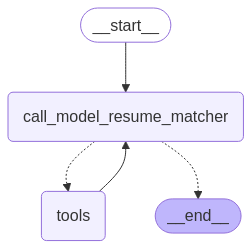

In [ ]:
# --------------------------
# Step 7: Display Graph
# --------------------------
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        resume_matcher_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# ---------------------------------
# Step 8: Run Resume matcher Agent
# ---------------------------------
resume_result = resume_matcher_agent.invoke({
    "jd_output": result["jd_output"],
    "resume": "I have 2 years experence in JAVA"
})

print("Resume Match Result:", resume_result["match_result"])

Resume Match Result: The resume does not match the job description for the following reasons:

1. **Core Technical Skills**: The job description specifically requires experience in Python and Docker. The resume only mentions experience in Java, which means it does not fulfill the primary technical requirements of the role.

2. **Relevant Experience**: The resume does not include any information about server-side application development, problem-solving skills related to backend development, or experience with containerization technologies, which are also emphasized in the job description.

Given these factors, I would assign a very low match percentage of **10%**. The lack of relevant skills in Python and Docker significantly affects the candidate's suitability for this specific position.


##**OnBoard Process Agent**

In [ ]:
# --------------------------------
#  Step 1: Onboarding Agent Setup
# --------------------------------
class OnboardInputState(TypedDict):
    resume: str
    jd_output: str

class OnboardOutputState(TypedDict):
    onboarding_result: str

class OnboardState(OnboardInputState, OnboardOutputState):
    messages: Annotated[List[BaseMessage], add]

# --------------------------
# Step 2: Define Tool
# --------------------------
@tool
def simulate_onboarding(resume: str, jd_output: str) -> str:
    """Simulate onboarding process for selected candidate"""
    return f"Candidate with resume '{resume[:30]}...' has been successfully onboarded for JD: '{jd_output[:30]}...'."

tools_onboard = [simulate_onboarding]
model_onboard = llm.bind_tools(tools_onboard)

# --------------------------
# Step 3: Agent Logic
# --------------------------
def call_onboarding_model(state: OnboardState) -> OnboardState:
    local_messages = state.get("messages", [])
    if not local_messages:
        local_messages.append(HumanMessage(
            content=f"Please onboard the candidate for the following JD:\n\n{state['jd_output']}\n\nResume:\n{state['resume']}"
        ))

    system_message = SystemMessage(content="You are an onboarding automation assistant. Complete onboarding based on JD and resume.")

    response = model_onboard.invoke([system_message] + local_messages)

    state["onboarding_result"] = response.content
    state["messages"] = local_messages + [response]
    return state

def should_continue_onboarding(state: OnboardState) -> Literal["tools", END]:
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    return END

# ----------------------------------
# Step 4: Onboarding Agent SubGraph
# ----------------------------------
onboard_graph = StateGraph(OnboardState, input=OnboardInputState, output=OnboardOutputState)
onboard_graph.add_node("call_onboarding_model", call_onboarding_model)
onboard_graph.add_node("tools", ToolNode(tools_onboard))
onboard_graph.add_edge(START, "call_onboarding_model")
onboard_graph.add_conditional_edges("call_onboarding_model", should_continue_onboarding)
onboard_graph.add_edge("tools", "call_onboarding_model")

onboard_agent = onboard_graph.compile()


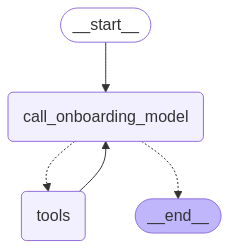

In [ ]:
# --------------------------
# Step 5: display Graph
# --------------------------
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        onboard_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# -----------------------------
# Step 6: Run Onboarding Agent
# -----------------------------
onboard_result = onboard_agent.invoke({
    "resume": resume,
    "jd_output": result["jd_output"],
})


In [ ]:
print(onboard_result)

{'onboarding_result': 'The candidate has been successfully onboarded for the Data Scientist position.'}


##**Supervisor Agent with Human in the loop**

In [ ]:
# --------------------------------
# Step 1: Supervisor Agent Schema
# --------------------------------
class SupervisorState(TypedDict):
    requirements: str
    resume: str
    jd_output: str
    match_result: str
    match_percent: int  # Added to store extracted percentage
    interview_decision: str  # Human input: 'Selected' or 'Rejected'
    onboarding_result: str
    decision: str
    steps_done: List[str]

# -------------------------------
# Step 2: Supervisor Agent Logic
# -------------------------------
def jd_node(state: SupervisorState) -> SupervisorState:
    if "jd_node" not in state["steps_done"]:
        jd_output = jd_generator_agent.invoke({"requirement": state["requirements"]})
        state["jd_output"] = jd_output["jd_output"]
        state["steps_done"].append("jd_node")
    return state

import re

def resume_match_node(state: SupervisorState) -> SupervisorState:
    if "resume_match_node" not in state["steps_done"]:
        result = resume_matcher_agent.invoke({
            "jd_output": state["jd_output"],
            "resume": state["resume"]
        })
        state["match_result"] = result["match_result"]

        # Debugging: Print the match result
        print("Match Result:", state["match_result"])

        # Extract match percentage
        match = re.search(r"Match Percentage:\s*(\d+)%", state["match_result"])
        if match:
            match_percent = int(match.group(1))
            state["match_percent"] = match_percent
        else:
            state["match_percent"] = 0

        state["steps_done"].append("resume_match_node")
    return state


def human_interview_node(state: SupervisorState) -> SupervisorState:
    if "human_interview_node" not in state["steps_done"]:
        print("👨‍💼 Please enter the interview result (Selected / Rejected):")
        state["interview_decision"] = input(">> ").strip()
        state["steps_done"].append("human_interview_node")
    return state

def onboard_process_node(state: SupervisorState) -> SupervisorState:
    if "onboard_process_node" not in state["steps_done"]:
        result = onboard_agent.invoke({
            "resume": state["resume"],
            "jd_output": state["jd_output"]
        })
        state["onboarding_result"] = result["onboarding_result"]
        state["decision"] = "Selected and Onboarded"
        state["steps_done"].append("onboard_process_node")
    return state

def supervisor_node(state: SupervisorState) -> SupervisorState:
    return state

def route_supervisor(state: SupervisorState) -> str:
    if state["decision"]:
        print("✅ Decision already made:", state["decision"])
        return "end"
    if "jd_node" not in state["steps_done"]:
        return "jd_node"
    if "resume_match_node" not in state["steps_done"]:
        return "resume_match_node"
    # Use the extracted match percentage for early rejection
    if state.get("match_percent", 0) < 40:
        state["decision"] = f"Rejected (Match Percentage: {state['match_percent']}%)"
        print("❌ Early rejection due to low resume match score.")
        return "end"
    if "human_interview_node" not in state["steps_done"]:
        return "human_interview_node"
    if state["interview_decision"].lower() == "rejected":
        state["decision"] = "Rejected by Interviewer"
        return "end"
    if "onboard_process_node" not in state["steps_done"]:
        return "onboard_process_node"
    return "end"

# -------------------------------
# Step 3: Supervisor Agent Graph
# -------------------------------
from langgraph.graph import StateGraph, END
graph = StateGraph(SupervisorState)
graph.add_node("supervisor_node", supervisor_node)
graph.add_node("jd_node", jd_node)
graph.add_node("resume_match_node", resume_match_node)
graph.add_node("human_interview_node", human_interview_node)
graph.add_node("onboard_process_node", onboard_process_node)

graph.set_entry_point("supervisor_node")
graph.add_edge("jd_node", "supervisor_node")
graph.add_edge("resume_match_node", "supervisor_node")
graph.add_edge("human_interview_node", "supervisor_node")
graph.add_edge("onboard_process_node", "supervisor_node")
graph.add_conditional_edges(
    "supervisor_node",
    route_supervisor,
    {
        "jd_node": "jd_node",
        "resume_match_node": "resume_match_node",
        "human_interview_node": "human_interview_node",
        "onboard_process_node": "onboard_process_node",
        "end": END
    }
)

# Compile the Supervisor Agent Graph
supervisor_agent = graph.compile()

Match Result: Based on the job description (JD), the key technical skills required are:

1. Expertise in Python
2. Expertise in Docker
3. Familiarity with RESTful APIs
4. Database management is preferred

The resume provided indicates:

- 5 years of experience in Java
- 3 years of experience in Python
- Strong problem-solving skills
- Experience with RESTful APIs

### Assessment:
- The resume includes Python experience, which aligns with the job requirements.
- However, the resume **does not mention Docker**, which is a core technical skill explicitly required for the position.
- The experience with RESTful APIs is a positive point and relevant to the role, but it does not compensate for the lack of Docker expertise.

### Conclusion:
Given the lack of Docker in the resume, I would assign a lower match percentage, specifically around **40%**, primarily due to the absence of the required Docker skill despite the presence of Python and relevant experience with RESTful APIs.

**Match Perce

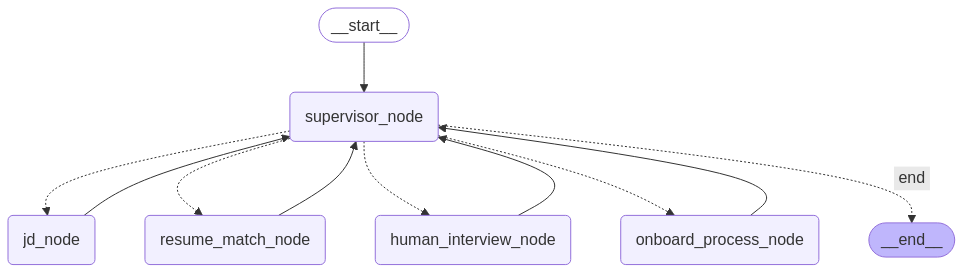

In [ ]:
# --------------------------
# Step 4: Display Graph
# --------------------------
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        supervisor_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# ---------------------------------
# Step 5: Run the supervisor agent
# ---------------------------------
result = supervisor_agent.invoke(SupervisorState(
    requirements="Looking for a backend developer with Python and Docker experience.",
    resume="5 years experience in Java and 6 years experience in python and strong problem-solving skills and experience with RESTful APIs",
    #resume="3 years experience in Excel"
    jd_output="",
    match_result="",
    match_percent=0,
    interview_decision="",
    onboarding_result="",
    decision="",
    steps_done=[]
))

print("\n📝 Final State:")
print(result)

Match Result: The resume provided has relevant experience in Python, as indicated by "6 years experience in python" and mentions strong problem-solving skills and experience with RESTful APIs. However, it does not mention Docker, which is a core technical skill explicitly required by the job description.

Given the importance of the required skills, especially the absence of Docker on the resume, I would assess the match percentage as follows:

- Presence of Python: High relevance (6 years).
- Absence of Docker: Significant gap.
- Relevant soft skills (problem-solving and communication): Positive, but not core technical.

**Match Percentage: 60%**

This score reflects the candidate's strong experience in Python and relevant soft skills, while the lack of Docker knowledge greatly impacts their suitability for the role.
👨‍💼 Please enter the interview result (Selected / Rejected):
>> Selected
✅ Decision already made: Selected and Onboarded

📝 Final State:
{'requirements': 'Looking for a b